**Data exploration and preprocessing of the dataset.**

looking for:

Are there any missing values (NaN) in Longitude or Latitude?

Do the coordinates make sense?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


file_path = '/content/sample_data/MLDataset.csv'
data = pd.read_csv(file_path, sep=";")

print("Dataset Info:")
print(data.info())
print("\nFirst 5 rows:")
print(data.head())
print("\nSummary statistics:")
print(data.describe())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9895 entries, 0 to 9894
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  9895 non-null   float64
 1   Latitude   9895 non-null   float64
dtypes: float64(2)
memory usage: 154.7 KB
None

First 5 rows:
   Longitude  Latitude
0  36.861544 -5.177747
1  51.463766  5.392935
2  51.190492  4.453765
3  51.326247  6.085953
4  51.463766  5.392935

Summary statistics:
         Longitude     Latitude
count  9895.000000  9895.000000
mean     47.798423     4.763722
std       5.779548     8.706026
min      34.910655   -10.466312
25%      41.322100    -1.787456
50%      49.654149     0.742880
75%      52.661300    11.692222
max      59.450561    45.307594

Missing values:
Longitude    0
Latitude     0
dtype: int64


Key Insights:

Duplicates: There are repeated coordinates, which might skew clustering results.

Outliers: Some points are far from the main clusters

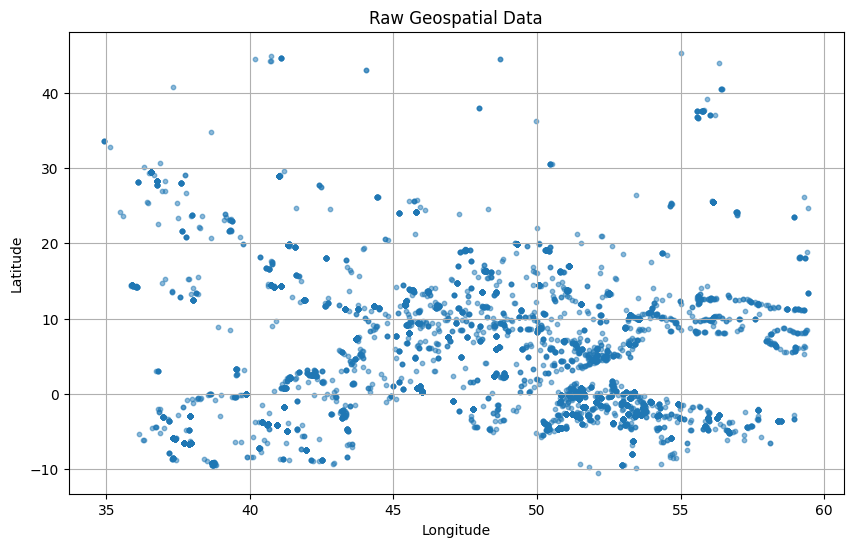

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data['Longitude'], data['Latitude'], s=10, alpha=0.5)
plt.title('Raw Geospatial Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

Geographical Spread: The data spans a large area, so distance-based clustering might work well, but we need to be careful with distance metrics since 1° of latitude/longitude varies in real-world distance depending on the location.

Cluster Patterns: The scatter plot shows dense regions, suggesting that density-based clustering (DBSCAN/HDBSCAN) might be more appropriate than partition-based methods like K-Means.

Preprocessing the Data:

Removed Duplicates: To avoid over-representing certain locations.

Outlier Detection and Removal: To focus on the main clusters and reduce noise.

Distance Considerations: For geospatial data, need to decide whether to use raw coordinates or a distance metric that accounts for the Earth’s curvature (e.g., Haversine distance) by testing.

Rows after removing duplicates: 5930 (Original: 9895)
Rows after removing outliers: 5878


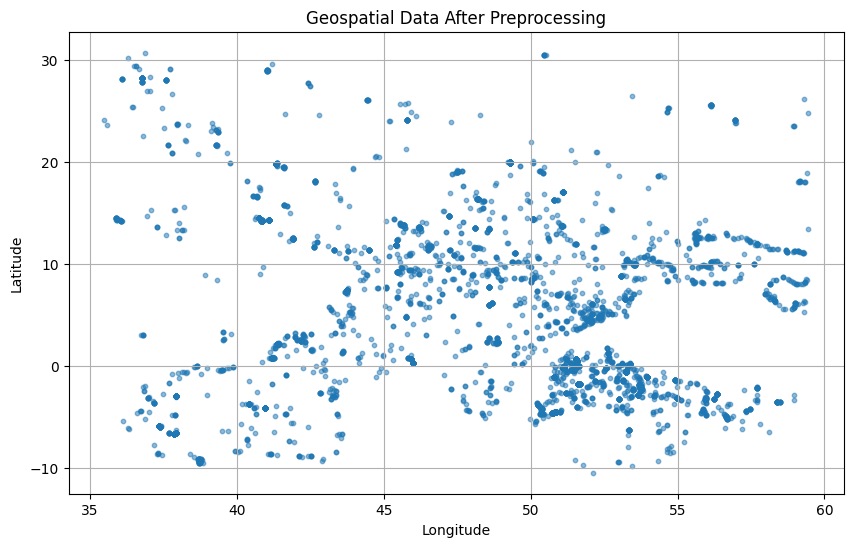

In [ ]:
import pandas as pd
import numpy as np


# 1. Removing Duplicates
data_no_duplicates = data.drop_duplicates()
print(f"Rows after removing duplicates: {len(data_no_duplicates)} (Original: {len(data)})")

# 2. Outlier Detection and Removal
# using a simple statistical method: remove points beyond 1.5 * IQR (Interquartile Range)

Q1 = data_no_duplicates.quantile(0.25)
Q3 = data_no_duplicates.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering out outliers
data_cleaned = data_no_duplicates[
    (data_no_duplicates['Longitude'].between(lower_bound['Longitude'], upper_bound['Longitude'])) &
    (data_no_duplicates['Latitude'].between(lower_bound['Latitude'], upper_bound['Latitude']))
]
print(f"Rows after removing outliers: {len(data_cleaned)}")

# 3. Checking the cleaned data with a scatter plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned['Longitude'], data_cleaned['Latitude'], s=10, alpha=0.5)
plt.title('Geospatial Data After Preprocessing')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

# 4. Preparing the data for clustering
# using raw coordinates for now, but we can switch to Haversine distance if needed after testing more.
coords = data_cleaned[['Longitude', 'Latitude']].values

In [ ]:
#saving the preprocessed dataset
output_file = '/content/sample_data/locations_preprocessed.csv'
data_cleaned.to_csv(output_file, index=False)
print(f"Preprocessed dataset saved to: {output_file}")

Preprocessed dataset saved to: /content/sample_data/locations_preprocessed.csv


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Silhouette Scores:
K-Means: 0.506
DBSCAN: 0.286
HDBSCAN: 0.409
Hierarchical: 0.490


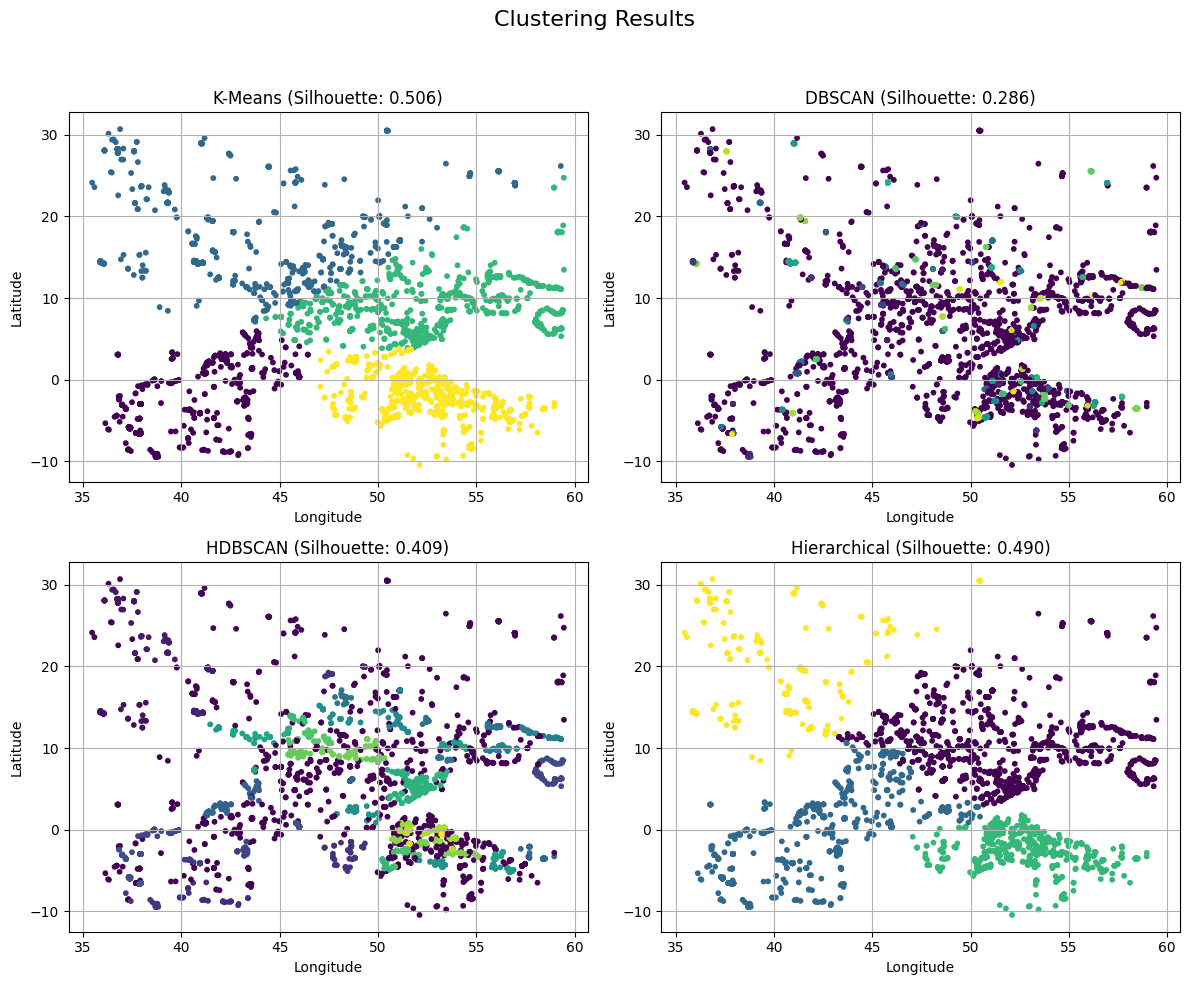

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import hdbscan
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load the preprocessed dataset
data_cleaned = pd.read_csv('/content/sample_data/locations_preprocessed.csv')
coords = data_cleaned[['Longitude', 'Latitude']].values

# 1. K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(coords)
kmeans_silhouette = silhouette_score(coords, kmeans_labels) if len(set(kmeans_labels)) > 1 else -1

# 2. DBSCAN
# eps in degrees; 0.1° ≈ 11 km at the equator
dbscan = DBSCAN(eps=0.1, min_samples=10)
dbscan_labels = dbscan.fit_predict(coords)
dbscan_silhouette = silhouette_score(coords, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

# 3. HDBSCAN
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10)
hdbscan_labels = hdbscan_clusterer.fit_predict(coords)
hdbscan_silhouette = silhouette_score(coords, hdbscan_labels) if len(set(hdbscan_labels)) > 1 else -1

# 4. Hierarchical
hierarchical = AgglomerativeClustering(n_clusters=4)
hierarchical_labels = hierarchical.fit_predict(coords)
hierarchical_silhouette = silhouette_score(coords, hierarchical_labels) if len(set(hierarchical_labels)) > 1 else -1

# Printing silhouette scores
print(f"Silhouette Scores:")
print(f"K-Means: {kmeans_silhouette:.3f}")
print(f"DBSCAN: {dbscan_silhouette:.3f}")
print(f"HDBSCAN: {hdbscan_silhouette:.3f}")
print(f"Hierarchical: {hierarchical_silhouette:.3f}")

# Visualize the clusters
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Clustering Results', fontsize=16)

# K-Means
axes[0, 0].scatter(coords[:, 0], coords[:, 1], c=kmeans_labels, s=10, cmap='viridis')
axes[0, 0].set_title(f'K-Means (Silhouette: {kmeans_silhouette:.3f})')

# DBSCAN
axes[0, 1].scatter(coords[:, 0], coords[:, 1], c=dbscan_labels, s=10, cmap='viridis')
axes[0, 1].set_title(f'DBSCAN (Silhouette: {dbscan_silhouette:.3f})')

# HDBSCAN
axes[1, 0].scatter(coords[:, 0], coords[:, 1], c=hdbscan_labels, s=10, cmap='viridis')
axes[1, 0].set_title(f'HDBSCAN (Silhouette: {hdbscan_silhouette:.3f})')

# Hierarchical
axes[1, 1].scatter(coords[:, 0], coords[:, 1], c=hierarchical_labels, s=10, cmap='viridis')
axes[1, 1].set_title(f'Hierarchical (Silhouette: {hierarchical_silhouette:.3f})')

for ax in axes.flat:
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Summary of Clustering Results:
K-Means (0.506): Best silhouette score, well-separated clusters but forces all points into clusters.

Hierarchical (0.490): Similar to K-Means, compact clusters, good performance.

HDBSCAN (0.409): Handles noise well, produces natural clusters but has a lower score.

DBSCAN (0.286): Struggles due to small eps, many points labeled as noise.

Key Takeaway: K-Means and Hierarchical perform best, but HDBSCAN is more flexible. DBSCAN needs parameter tuning.

lets try diffrent values to analyse more effectively

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Silhouette Scores (New Parameters):
K-Means (n_clusters=3): 0.412
K-Means (n_clusters=5): 0.526
DBSCAN (eps=0.2): 0.548
DBSCAN (eps=0.5): 0.315
HDBSCAN (min_cluster_size=10): 0.412
HDBSCAN (min_cluster_size=30): 0.373
Hierarchical (n_clusters=3): 0.473
Hierarchical (n_clusters=5): 0.486


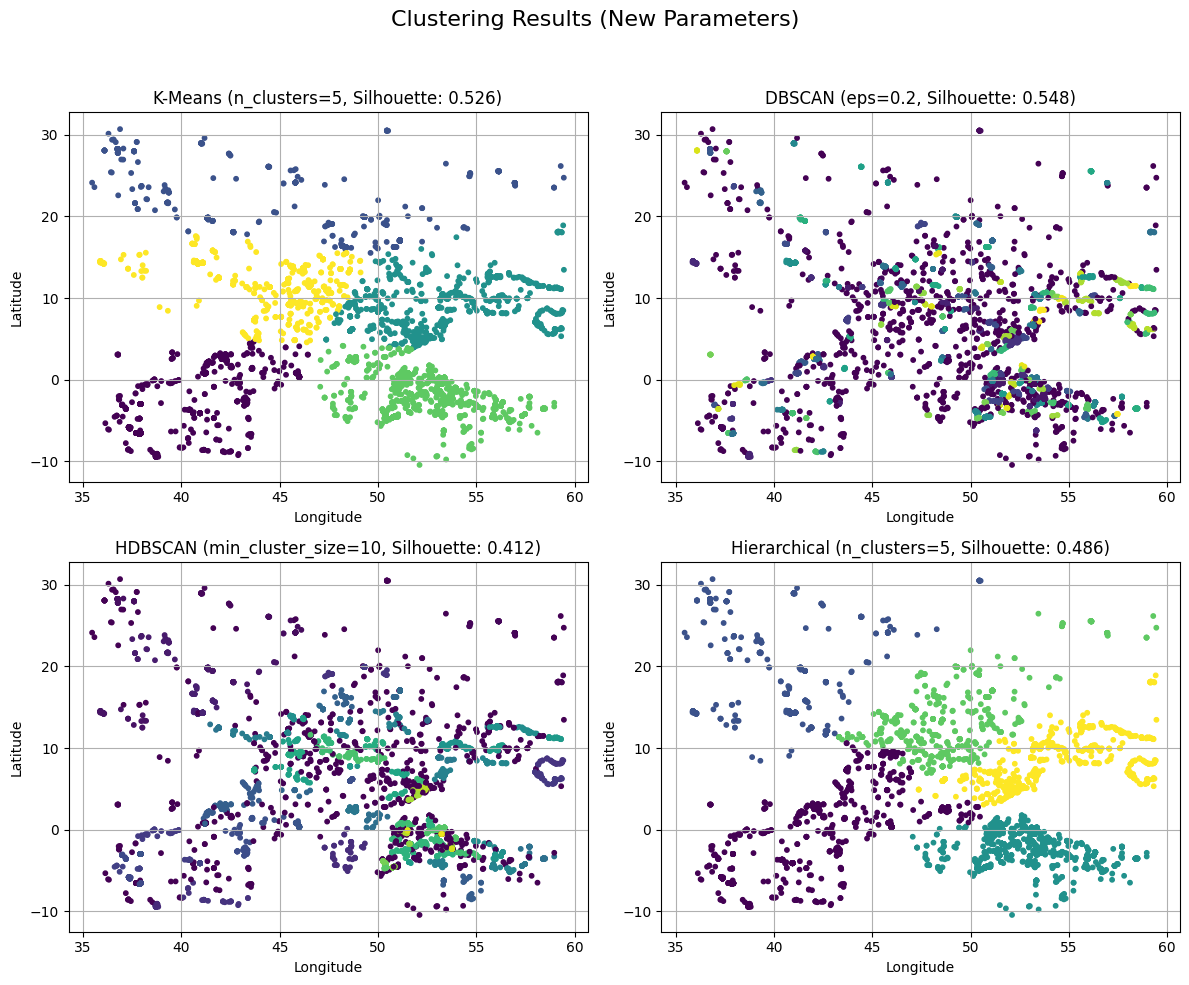

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import hdbscan
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load the preprocessed dataset
data_cleaned = pd.read_csv('/content/sample_data/locations_preprocessed.csv')
coords = data_cleaned[['Longitude', 'Latitude']].values

# 1. K-Means:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_3_labels = kmeans_3.fit_predict(coords)
kmeans_3_silhouette = silhouette_score(coords, kmeans_3_labels) if len(set(kmeans_3_labels)) > 1 else -1

kmeans_5 = KMeans(n_clusters=5, random_state=42)
kmeans_5_labels = kmeans_5.fit_predict(coords)
kmeans_5_silhouette = silhouette_score(coords, kmeans_5_labels) if len(set(kmeans_5_labels)) > 1 else -1

# 2. DBSCAN:
dbscan_02 = DBSCAN(eps=0.2, min_samples=5)
dbscan_02_labels = dbscan_02.fit_predict(coords)
dbscan_02_silhouette = silhouette_score(coords, dbscan_02_labels) if len(set(dbscan_02_labels)) > 1 else -1

dbscan_05 = DBSCAN(eps=0.5, min_samples=5)
dbscan_05_labels = dbscan_05.fit_predict(coords)
dbscan_05_silhouette = silhouette_score(coords, dbscan_05_labels) if len(set(dbscan_05_labels)) > 1 else -1

# 3. HDBSCAN:
hdbscan_10 = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
hdbscan_10_labels = hdbscan_10.fit_predict(coords)
hdbscan_10_silhouette = silhouette_score(coords, hdbscan_10_labels) if len(set(hdbscan_10_labels)) > 1 else -1

hdbscan_30 = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5)
hdbscan_30_labels = hdbscan_30.fit_predict(coords)
hdbscan_30_silhouette = silhouette_score(coords, hdbscan_30_labels) if len(set(hdbscan_30_labels)) > 1 else -1

# 4. Hierarchical:
hierarchical_3 = AgglomerativeClustering(n_clusters=3)
hierarchical_3_labels = hierarchical_3.fit_predict(coords)
hierarchical_3_silhouette = silhouette_score(coords, hierarchical_3_labels) if len(set(hierarchical_3_labels)) > 1 else -1

hierarchical_5 = AgglomerativeClustering(n_clusters=5)
hierarchical_5_labels = hierarchical_5.fit_predict(coords)
hierarchical_5_silhouette = silhouette_score(coords, hierarchical_5_labels) if len(set(hierarchical_5_labels)) > 1 else -1

# Print silhouette scores
print("Silhouette Scores (New Parameters):")
print(f"K-Means (n_clusters=3): {kmeans_3_silhouette:.3f}")
print(f"K-Means (n_clusters=5): {kmeans_5_silhouette:.3f}")
print(f"DBSCAN (eps=0.2): {dbscan_02_silhouette:.3f}")
print(f"DBSCAN (eps=0.5): {dbscan_05_silhouette:.3f}")
print(f"HDBSCAN (min_cluster_size=10): {hdbscan_10_silhouette:.3f}")
print(f"HDBSCAN (min_cluster_size=30): {hdbscan_30_silhouette:.3f}")
print(f"Hierarchical (n_clusters=3): {hierarchical_3_silhouette:.3f}")
print(f"Hierarchical (n_clusters=5): {hierarchical_5_silhouette:.3f}")

# Visualize the clusters (new parameters)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Clustering Results (New Parameters)', fontsize=16)

# K-Means (n_clusters=5)
axes[0, 0].scatter(coords[:, 0], coords[:, 1], c=kmeans_5_labels, s=10, cmap='viridis')
axes[0, 0].set_title(f'K-Means (n_clusters=5, Silhouette: {kmeans_5_silhouette:.3f})')

# DBSCAN (eps=0.2)
axes[0, 1].scatter(coords[:, 0], coords[:, 1], c=dbscan_02_labels, s=10, cmap='viridis')
axes[0, 1].set_title(f'DBSCAN (eps=0.2, Silhouette: {dbscan_02_silhouette:.3f})')

# HDBSCAN (min_cluster_size=10)
axes[1, 0].scatter(coords[:, 0], coords[:, 1], c=hdbscan_10_labels, s=10, cmap='viridis')
axes[1, 0].set_title(f'HDBSCAN (min_cluster_size=10, Silhouette: {hdbscan_10_silhouette:.3f})')

# Hierarchical (n_clusters=5)
axes[1, 1].scatter(coords[:, 0], coords[:, 1], c=hierarchical_5_labels, s=10, cmap='viridis')
axes[1, 1].set_title(f'Hierarchical (n_clusters=5, Silhouette: {hierarchical_5_silhouette:.3f})')

for ax in axes.flat:
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Summary of New Clustering Results:

DBSCAN (eps=0.2) → 0.548: Best silhouette score, balances cluster size and noise.

K-Means (n_clusters=5) → 0.526: Improved from 4 clusters, captures structure well.

Hierarchical (n_clusters=5) → 0.486: Compact clusters, slightly lower score than K-Means.

HDBSCAN (min_cluster_size=10) → 0.412: Slight improvement, but lower than DBSCAN/K-Means.

Key Takeaway: DBSCAN (eps=0.2) performs best, handling noise and natural clusters well. K-Means (n_clusters=5) is also strong for structured clustering.

**so now we are moving forward with DBSCAN since it performed better and it haldls the noise and natural clusters very well.**

**Final Clustering Code (Using DBSCAN with eps=0.2)**

Final DBSCAN (eps=0.2) Silhouette Score: 0.548
Clustered dataset saved to: locations_clustered.csv


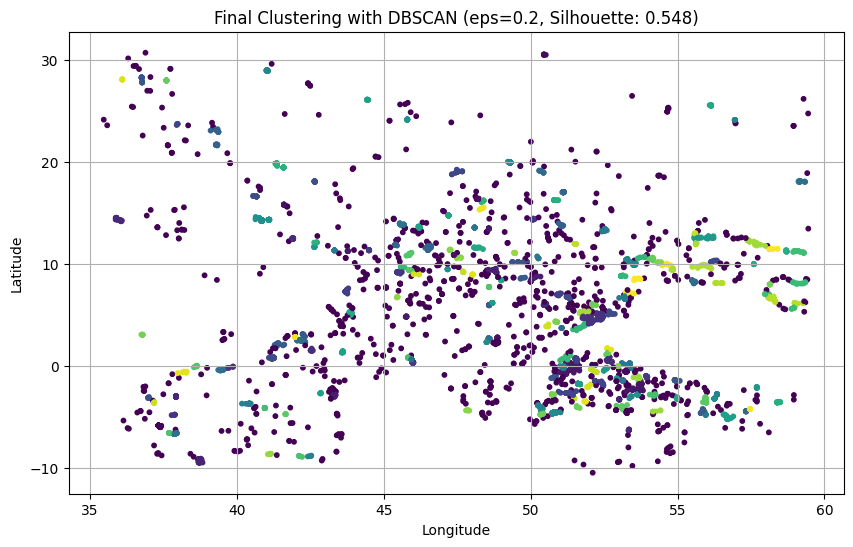

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Loading the preprocessed dataset
data_cleaned = pd.read_csv('/content/sample_data/locations_preprocessed.csv')
coords = data_cleaned[['Longitude', 'Latitude']].values

# Final clustering with DBSCAN (eps=0.2)
dbscan_final = DBSCAN(eps=0.2, min_samples=5)
dbscan_final_labels = dbscan_final.fit_predict(coords)
dbscan_final_silhouette = silhouette_score(coords, dbscan_final_labels) if len(set(dbscan_final_labels)) > 1 else -1

# Print the final silhouette score
print(f"Final DBSCAN (eps=0.2) Silhouette Score: {dbscan_final_silhouette:.3f}")

# Add cluster labels to the DataFrame
data_cleaned['Cluster'] = dbscan_final_labels

# Saving the dataset with cluster labels
data_cleaned.to_csv('/content/sample_data/locations_clustered.csv', index=False)
print("Clustered dataset saved to: locations_clustered.csv")

# Visualizing the final clusters
plt.figure(figsize=(10, 6))
plt.scatter(coords[:, 0], coords[:, 1], c=dbscan_final_labels, s=10, cmap='viridis')
plt.title(f'Final Clustering with DBSCAN (eps=0.2, Silhouette: {dbscan_final_silhouette:.3f})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

*Notes*

The Cluster column in the saved file will have values like 0, 1, 2, ... for different clusters, and -1 for noise points.